![Semillero Astrofisica](../logo.PNG)

---
# Sistemas de Ecuaciones Integrodiferenciales

Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver una ecuación integrodiferencial. Específicamente, la ecuación de Volterra https://www.hindawi.com/journals/jam/2017/1510267/. 

\begin{equation}
     y^{\prime}(x) + y(x) = \int_0^x e^{s-x}y(s) ds
\end{equation}

Como condición inicial
\begin{equation}
     y(0)=1
\end{equation}

La solución analítica de esta ecuación es 
\begin{equation}
     y(x)=e^{-x}\cosh{x}
\end{equation}

In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

Using backend: tensorflow.compat.v1

2022-10-20 22:31:24.045452: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 22:31:24.048837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 22:31:24.048852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-10-20 22:31:25.155669: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-20 22:31:25.155708: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Definir la Ecuación a Resolver

In [2]:
def IDE(x, y, int_mat):
    rhs = tf.matmul(int_mat, y)
    lhs1 = tf.gradients(y, x)[0]
    return (lhs1 + y)[: tf.size(rhs)] - rhs

def kernel(x, s):
    return np.exp(s - x)

def analytic_sol(x):
    return np.exp(-x)*np.cosh(x)

## 2. Definir Dominio de la Ecuación

Podemos aprovechar el dominio TimeDomain

~~~python
class deepxde.geometry.timedomain.TimeDomain(t0, t1)
~~~

Esta clase de dominio crea el booleano para definir las coondiciones iniciales

~~~pyhton
on_initial(t)
~~~

In [3]:
geom = dde.geometry.TimeDomain(0, 5)

## 3. Definir Condiciones Iniciales y de Frontera


In [4]:
IC = dde.icbc.IC(geom, lambda x: 1, lambda _, on_initial: on_initial)

## 4. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

~~~python
class deepxde.data.ide.IDE(geometry, 
                           ide, 
                           bcs, 
                           quad_deg, 
                           kernel=None, 
                           num_domain=0, 
                           num_boundary=0, 
                           train_distribution='Hammersley', 
                           anchors=None, 
                           solution=None, 
                           num_test=None)
~~~

Detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.IDE#deepxde.data.ide.IDE. quad_deg son los puntos de cuadratura de gauss para tomar.

Por ahora, solo soporta ecuaciones integrodiferenciales en 1D. Con el Kernel se puede especificar lo que hay dentro de la integral. 

In [5]:
quad_deg = 8
data = dde.data.IDE(geom, IDE, IC, quad_deg, kernel=kernel, num_domain=14, num_boundary=8, 
                    solution=analytic_sol,train_distribution='uniform')

## 5. Crear la Red Neuronal

Vamos a utilizar una **Fully-connected neural network**.

~~~python
class deepxde.nn.tensorflow.fnn.FNN(layer_sizes, activation, 
                                    kernel_initializer, 
                                    regularization=None, 
                                    dropout_rate=0)
~~~

In [6]:
layer_size = [1] + [40]*3 + [1] 
activation = "tanh"
initializer = "Glorot uniform"
regularization = ["l2", 1e-5]
dropout_rate = 0.0005

net = dde.nn.FNN(layer_size, activation, initializer, 
                 regularization=regularization, dropout_rate=dropout_rate)

## 6. Compilar y Entrenar el Modelo

Vamos a usar Adam para mostrar que las PINNs son bastante buenas con este tipo de problemas.

In [7]:
# Modelo
model = dde.Model(data, net)
uncertainty = dde.callbacks.DropoutUncertainty(period=500)

# Optimizador Adam
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000, callbacks=[uncertainty])

Compiling model...
Building feed-forward neural network...
'build' took 0.064424 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:86: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  y = tf.layers.dropout(y, rate=self.dropout_rate, training=self.training)
2022-10-20 22:31:26.529407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.356227 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [7.82e-03, 1.00e+00, 8.39e-04]    [7.42e-03, 0.00e+00, 8.39e-04]    [9.23e-01]    


2022-10-20 22:31:26.827510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [7.57e-05, 2.77e-06, 8.72e-04]    [7.13e-05, 0.00e+00, 8.72e-04]    [7.70e-03]    
2000      [1.49e-04, 1.37e-04, 8.18e-04]    [2.83e-05, 0.00e+00, 8.18e-04]    [8.02e-03]    
3000      [3.93e-04, 1.45e-05, 7.59e-04]    [1.62e-05, 0.00e+00, 7.59e-04]    [9.13e-03]    
4000      [3.94e-04, 3.56e-05, 6.97e-04]    [1.30e-05, 0.00e+00, 6.97e-04]    [5.76e-03]    
5000      [1.62e-04, 2.65e-05, 6.32e-04]    [1.33e-04, 0.00e+00, 6.32e-04]    [2.87e-02]    
6000      [2.78e-04, 1.99e-05, 5.73e-04]    [1.07e-05, 0.00e+00, 5.73e-04]    [1.10e-02]    
7000      [4.52e-04, 8.58e-06, 5.19e-04]    [1.02e-05, 0.00e+00, 5.19e-04]    [4.72e-03]    
8000      [7.66e-06, 2.85e-05, 4.66e-04]    [7.42e-06, 0.00e+00, 4.66e-04]    [7.96e-03]    
9000      [5.53e-06, 1.08e-06, 4.17e-04]    [5.87e-06, 0.00e+00, 4.17e-04]    [1.05e-02]    
10000     [4.65e-05, 4.59e-05, 3.72e-04]    [1.91e-05, 0.00e+00, 3.72e-04]    [6.11e-03]    
11000     [4.93e-05, 1.58e-05, 3.33e-04]    [2.06e-05, 0.00e+00, 3.33e

## 7. Visualizar la Solución

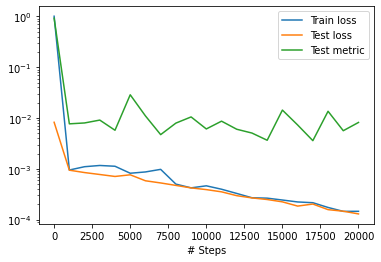

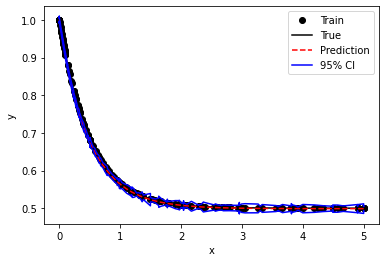

In [8]:
dde.utils.external.plot_loss_history(losshistory)
dde.utils.external.plot_best_state(train_state)

~~~python
uniform_points(n, boundary=True)
~~~

In [9]:
X = geom.uniform_points(1000)
y_true = analytic_sol(X)
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

L2 relative error: 0.011277567244674692
